# Inference finetuned classification model

- input: sentilnel 2
- output: classification class
- model: DoubleResNetSimCLRDownstream 
- dataloader: DFCDataset

Dataloader

In [1]:
import argparse
import json
import os
import sys
import random
import numpy as np
import torch
import wandb
import matplotlib.pyplot as plt
import torch.nn.functional as F
from distutils.util import strtobool
from tqdm import tqdm
from torchvision.models import resnet18, resnet50

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from dfc_dataset import DFCDataset
import torchvision.models as models
from exceptions import InvalidBackboneError

data_config = {
    'train_dir': '../data/data_disini', # path to the training directory,  
    'val_dir': '../data/data_disini', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 8, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

random.seed(data_config['seed'])
np.random.seed(data_config['seed'])
torch.manual_seed(data_config['seed'])
torch.cuda.manual_seed_all(data_config['seed'])

val_dataset = DFCDataset(
    data_config['val_dir'],
    mode=data_config['val_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['val_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_validation'],
    seed=data_config['seed'],
)

DFC_map_clean = {
    0: "Forest",
    1: "Shrubland",
    2: "Grassland",
    3: "Wetlands",
    4: "Croplands",
    5: "Urban/Built-up",
    6: "Barren",
    7: "Water",
    255: "Invalid",
}

train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': True, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999), 
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 16,
    'epochs': 5, 
    'target': 'dfc_label'
}

class DoubleResNetSimCLRDownstream(torch.nn.Module):
    """concatenate outputs from two backbones and add one linear layer"""

    def __init__(self, base_model, out_dim):
        super(DoubleResNetSimCLRDownstream, self).__init__()

        self.resnet_dict = {"resnet18": models.resnet18,
                            "resnet50": models.resnet50,}
        

        self.backbone2 = self.resnet_dict.get(base_model)(pretrained=False, num_classes=out_dim)
        dim_mlp2 = self.backbone2.fc.in_features
        
        # If you are using multimodal data you can un-comment the following lines:
        # self.backbone1 = self.resnet_dict.get(base_model)(pretrained=False, num_classes=out_dim)
        # dim_mlp1 = self.backbone1.fc.in_features
        
        # add final linear layer
        self.fc = torch.nn.Linear(dim_mlp2, out_dim, bias=True)
        # self.fc = torch.nn.Linear(dim_mlp1 + dim_mlp2, out_dim, bias=True)

        # self.backbone1.fc = torch.nn.Identity()
        self.backbone2.fc = torch.nn.Identity()

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
        except KeyError:
            raise InvalidBackboneError(
                "Invalid backbone architecture. Check the config file and pass one of: resnet18 or resnet50")
        else:
            return model

    def forward(self, x):
        x2 = self.backbone2(x["s2"])

        # If you are using multimodal data you can un-comment the following lines and comment z = self.fc(x2):
        # x1 = self.backbone1(x["s1"])
        # z = torch.cat([x1, x2], dim=1)
        # z = self.fc(z)
     
        z = self.fc(x2)
        
        return z
    
    def load_trained_state_dict(self, weights):
        """load the pre-trained backbone weights"""
        
        # remove the MLP projection heads
        for k in list(weights.keys()):
            if k.startswith(('backbone1.fc', 'backbone2.fc')):
                del weights[k]
        
        log = self.load_state_dict(weights, strict=False)
        assert log.missing_keys == ['fc.weight', 'fc.bias']
        
        # freeze all layers but the last fc
        for name, param in self.named_parameters():
            if name not in ['fc.weight', 'fc.bias']:
                param.requires_grad = False

base_model = "resnet50"
num_classes = 8

model = eval('DoubleResNetSimCLRDownstream')(base_model, num_classes)

model.backbone2.conv1 = torch.nn.Conv2d(
    train_config['s2_input_channels'],
    64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False,
)

device = torch.device("cpu")
model.load_state_dict(torch.load("../checkpoints/Classifier epoch 195.pth", map_location=torch.device('cpu')))
model.to(device)

# Inference
img = {"s2": torch.unsqueeze(val_dataset[2]['s2'].to(device), 0)} # adding an extra dimension for batch information
model.eval()
output = model(img)

print(f'Predicted class: {DFC_map_clean[torch.argmax(output).item()]}')
print('Ground-truth class: ', DFC_map_clean[val_dataset[2][train_config['target']]])

/Users/aradinka/miniforge3/envs/ssl/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


Predicted class: Croplands
Ground-truth class:  Croplands


Manual

In [8]:
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

import rasterio
from rasterio.windows import Window
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.models as models

from utils import AlbumentationsToTorchTransform
import torch


class S1Bands(Enum):
    VV = 1
    VH = 2
    ALL = [VV, VH]
    NONE = None

class Sensor(Enum):
    s1 = "s1"
    s2 = "s2"
    lc = "lc"
    dfc = "dfc"

class S2Bands(Enum):
    B01 = aerosol = 1
    B02 = blue = 2
    B03 = green = 3
    B04 = red = 4
    B05 = re1 = 5
    B06 = re2 = 6
    B07 = re3 = 7
    B08 = nir1 = 8
    B08A = nir2 = 9
    B09 = vapor = 10
    B10 = cirrus = 11
    B11 = swir1 = 12
    B12 = swir2 = 13
    ALL = [B01, B02, B03, B04, B05, B06, B07, B08, B08A, B09, B10, B11, B12]
    RGB = [B04, B03, B02]
    NONE = None

class LCBands(Enum):
    LC = lc = 0
    DFC = dfc = 1
    ALL = [DFC]
    NONE = None

class DoubleSwinTransformerClassifier(torch.nn.Module):
    def __init__(self, encoder1, encoder2, out_dim, device, freeze_layers=True):
        super(DoubleSwinTransformerClassifier, self).__init__()
        
        # If you're only using one of the two backbones, just comment the one you don't need
        self.backbone1 = encoder1
        self.backbone2 = encoder2

        self.device = device

        # add final linear layer
        self.fc = torch.nn.Linear(
            self.backbone2.num_features + self.backbone1.num_features,
            out_dim,
            bias=True,
        )

        # freeze all layers but the last fc
        if freeze_layers:
            for name, param in self.named_parameters():
                if name not in ["fc.weight", "fc.bias"]:
                    param.requires_grad = False

    def forward(self, x):
        x1, _, _ = self.backbone1.forward_features(x["s1"].to(self.device))
        x2, _, _ = self.backbone2.forward_features(x["s2"].to(self.device))

        z = torch.cat([x1, x2], dim=1)
        z = self.fc(z)
        
        # If you're only using one of the two backbones, you may comment the lines above and use the following:
        # x1, _, _ = self.backbone1.forward_features(x["s1"].to(self.device))
        # z = self.fc(x1)

        return z

class DoubleResNetSimCLRDownstream(torch.nn.Module):
    """concatenate outputs from two backbones and add one linear layer"""

    def __init__(self, base_model, out_dim):
        super(DoubleResNetSimCLRDownstream, self).__init__()

        self.resnet_dict = {"resnet18": models.resnet18,
                            "resnet50": models.resnet50,}
        

        self.backbone2 = self.resnet_dict.get(base_model)(pretrained=False, num_classes=out_dim)
        dim_mlp2 = self.backbone2.fc.in_features
        
        # If you are using multimodal data you can un-comment the following lines:
        # self.backbone1 = self.resnet_dict.get(base_model)(pretrained=False, num_classes=out_dim)
        # dim_mlp1 = self.backbone1.fc.in_features
        
        # add final linear layer
        self.fc = torch.nn.Linear(dim_mlp2, out_dim, bias=True)
        # self.fc = torch.nn.Linear(dim_mlp1 + dim_mlp2, out_dim, bias=True)

        # self.backbone1.fc = torch.nn.Identity()
        self.backbone2.fc = torch.nn.Identity()

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
        except KeyError:
            raise InvalidBackboneError(
                "Invalid backbone architecture. Check the config file and pass one of: resnet18 or resnet50")
        else:
            return model

    def forward(self, x):
        x2 = self.backbone2(x["s2"])

        # If you are using multimodal data you can un-comment the following lines and comment z = self.fc(x2):
        # x1 = self.backbone1(x["s1"])
        # z = torch.cat([x1, x2], dim=1)
        # z = self.fc(z)
     
        z = self.fc(x2)
        
        return z
    
    def load_trained_state_dict(self, weights):
        """load the pre-trained backbone weights"""
        
        # remove the MLP projection heads
        for k in list(weights.keys()):
            if k.startswith(('backbone1.fc', 'backbone2.fc')):
                del weights[k]
        
        log = self.load_state_dict(weights, strict=False)
        assert log.missing_keys == ['fc.weight', 'fc.bias']
        
        # freeze all layers but the last fc
        for name, param in self.named_parameters():
            if name not in ['fc.weight', 'fc.bias']:
                param.requires_grad = False


def get_patch(patch_path, bands, window=None):
    """
        Returns raster data and image bounds for the defined bands of a specific patch
        This method only loads a sinlge patch from a single sensor as defined by the bands specified
    """
    # season = Seasons(season).value
    sensor = None

    if not bands:
        return None, None

    if isinstance(bands, (list, tuple)):
        b = bands[0]
    else:
        b = bands
    
    if isinstance(b, S1Bands):
        sensor = Sensor.s1.value
        bandEnum = S1Bands
    elif isinstance(b, S2Bands):
        sensor = Sensor.s2.value
        bandEnum = S2Bands
    elif isinstance(b, LCBands):
        if LCBands(bands) == LCBands.LC:
            sensor = Sensor.lc.value 
        else:
            sensor = Sensor.dfc.value 

        bands = LCBands(1)
        bandEnum = LCBands
    else:
        raise Exception("Invalid bands specified")

    if isinstance(bands, (list, tuple)):
        bands = [b.value for b in bands]
    else:
        bands = bandEnum(bands).value

    with rasterio.open(patch_path) as patch:
        if window is not None:
            data = patch.read(bands, window=window) 
        else:
            data = patch.read(bands)
        bounds = patch.bounds

    # Remap IGBP to DFC bands
    # if sensor  == "lc":
    #     data = IGBP2DFC[data]

    if len(data.shape) == 2:
        data = np.expand_dims(data, axis=0)

    return data, bounds

def read_s2(patch_path):
    image_px_size = 224
    if image_px_size != 256:
        x_offset, y_offset = np.random.randint(0, 256 - image_px_size, 2)
        window = Window(x_offset, y_offset, image_px_size, image_px_size)
    else:
        window = None
    s2, bounds2 = get_patch(patch_path=patch_path, bands=S2Bands.ALL, window=window)
    clip_sample_values = True
    if clip_sample_values: s2 = np.clip(s2, a_min=0, a_max=1e4)

    base_aug = A.Compose([ToTensorV2()])
    base_transform = AlbumentationsToTorchTransform(base_aug)
    s2 = base_transform(np.moveaxis(s2, 0, -1))
    
    s2_maxs = []
    for b_idx in range(s2.shape[0]):
        s2_maxs.append(
            torch.ones((s2.shape[-2], s2.shape[-1])) * s2[b_idx].max().item() + 1e-5
        )
    s2_maxs = torch.stack(s2_maxs)
    normalize = True
    if normalize: s2 = s2 / s2_maxs
    return s2.float()

train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': True, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999), 
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 16,
    'epochs': 5, 
    'target': 'dfc_label'
}

DFC_map_clean = {
    0: "Forest",
    1: "Shrubland",
    2: "Grassland",
    3: "Wetlands",
    4: "Croplands",
    5: "Urban/Built-up",
    6: "Barren",
    7: "Water",
    255: "Invalid",
}

/Users/aradinka/miniforge3/envs/ssl/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


Predicted class: Wetlands


Text(0.5, 1.0, 'ROIs0000_test_s2_0_p3041.tif: Wetlands')

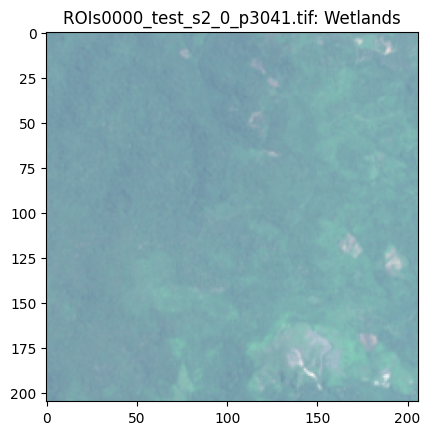

In [16]:
import os

img_dir = "../data/data_disini/ROIs0000_test/s2_0"
tif_files = [file for file in os.listdir(img_dir) if file.endswith(".tif")]
selected_tif = np.random.choice(tif_files)
random_tif = img_dir + "/" + selected_tif

s2 = read_s2("../data/data_disini/ROIs0000_test/s2_0/ROIs0000_test_s2_0_p4548.tif")
s2 = read_s2("../data/training_cacao/training_30.tif")
# s2 = read_s2(random_tif)

base_model = "resnet50"
num_classes = 8
model = eval('DoubleResNetSimCLRDownstream')(base_model, num_classes)
model.backbone2.conv1 = torch.nn.Conv2d(
    train_config['s2_input_channels'],
    64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False,
)

device = torch.device("cpu")
model.load_state_dict(torch.load("../checkpoints/Classifier epoch 195.pth", map_location=torch.device('cpu')))
model.to(device)

img = {"s2": torch.unsqueeze(s2.to(device), 0)}
model.eval()
output = model(img)
pred_class = DFC_map_clean[torch.argmax(output).item()]
print(f'Predicted class: {pred_class}')

img = np.moveaxis(s2.numpy(), 0, -1)
img = img / img.max(axis=(0, 1))
rgb_image = img[:, :, [3, 2, 1]]
plt.imshow(rgb_image)
plt.title(f"{selected_tif}: {pred_class}")

## Playground

Inference manual

In [ ]:
image_px_size = 224
if image_px_size != 256:
    # crop the data to image_px_size times image_px_size (e.g. 128x128)
    x_offset, y_offset = np.random.randint(0, 256 - image_px_size, 2)
    window = Window(x_offset, y_offset, image_px_size, image_px_size)
else:
    window = None

s1, bounds1 = get_patch(patch_path="../data/data_disini/ROIs0000_test/s1_0/ROIs0000_test_s1_0_p4548.tif", bands=S1Bands.ALL, window=window)
s2, bounds2 = get_patch(patch_path="../data/data_disini/ROIs0000_test/s2_0/ROIs0000_test_s2_0_p4548.tif", bands=S2Bands.ALL, window=window)

clip_sample_values = True
if clip_sample_values:
    s1 = np.clip(s1, a_min=-25, a_max=0)
    s1 = (
        s1 + 25
    )  # go from [-25,0] to [0,25] interval to make normalization easier
    s2 = np.clip(s2, a_min=0, a_max=1e4)

base_aug = A.Compose([ToTensorV2()])
base_transform = AlbumentationsToTorchTransform(base_aug)

s1 = base_transform(np.moveaxis(s1, 0, -1))
s2 = base_transform(np.moveaxis(s2, 0, -1))

s1_maxs = []
for ch_idx in range(s1.shape[0]):
    s1_maxs.append(
        torch.ones((s1.shape[-2], s1.shape[-1])) * s1[ch_idx].max().item()
        + 1e-5
    )
s1_maxs = torch.stack(s1_maxs)
s2_maxs = []
for b_idx in range(s2.shape[0]):
    s2_maxs.append(
        torch.ones((s2.shape[-2], s2.shape[-1])) * s2[b_idx].max().item() + 1e-5
    )
s2_maxs = torch.stack(s2_maxs)
normalize = True
if normalize:
    s1 = s1 / s1_maxs
    s2 = s2 / s2_maxs

In [ ]:
s2 = s2.float()
img = {"s2": torch.unsqueeze(s2.to(device), 0)} # adding an extra dimension for batch information
model.eval()
output = model(img)

print(f'Predicted class: {DFC_map_clean[torch.argmax(output).item()]}')
# print('Ground-truth class: ', DFC_map_clean[val_dataset[2][train_config['target']]])

Load sentinel 2

In [1]:
patch_path = "../data/data_disini/ROIs0000_test/s2_0/ROIs0000_test_s2_0_p4548.tif"

from enum import Enum
class S2Bands(Enum):
    B01 = aerosol = 1
    B02 = blue = 2
    B03 = green = 3
    B04 = red = 4
    B05 = re1 = 5
    B06 = re2 = 6
    B07 = re3 = 7
    B08 = nir1 = 8
    B08A = nir2 = 9
    B09 = vapor = 10
    B10 = cirrus = 11
    B11 = swir1 = 12
    B12 = swir2 = 13
    ALL = [B01, B02, B03, B04, B05, B06, B07, B08, B08A, B09, B10, B11, B12]
    RGB = [B04, B03, B02]
    NONE = None

bands = S2Bands.ALL
bands

<S2Bands.ALL: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]>

In [2]:
import numpy as np
from rasterio.windows import Window

image_px_size = 224
if image_px_size != 256:
    x_offset, y_offset = np.random.randint(0, 256 - image_px_size, 2)
    window = Window(x_offset, y_offset, image_px_size, image_px_size)
else:
    window = None
window

Window(col_off=17, row_off=9, width=224, height=224)

In [3]:
if isinstance(bands, (list, tuple)):
    print("True")
    b = bands[0]
else:
    b = bands
b

<S2Bands.ALL: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]>

In [4]:
class Sensor(Enum):
    s1 = "s1"
    s2 = "s2"
    lc = "lc"
    dfc = "dfc"

if isinstance(b, S2Bands):
    print(True)
    sensor = Sensor.s2.value
    bandEnum = S2Bands

print(sensor, bandEnum)

True
s2 <enum 'S2Bands'>


In [5]:
if isinstance(bands, (list, tuple)):
    bands = [b.value for b in bands]
else:
    bands = bandEnum(bands).value
bands

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [12]:
window

Window(col_off=17, row_off=9, width=224, height=224)

In [8]:
import rasterio
with rasterio.open(patch_path) as patch:
    if window is not None:
        print("Window not None")
        data = patch.read(bands, window=window) 
    else:
        data = patch.read(bands)
    bounds = patch.bounds

data.shape

Window not None


(13, 224, 224)

Import reshape to 224

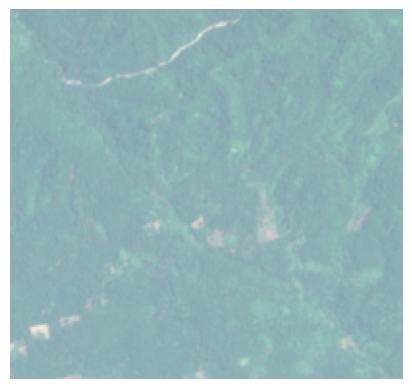

In [23]:
# one call import
patch_path = "../data/data_disini/ROIs0000_test/s2_0/ROIs0000_test_s2_0_p4559.tif"
patch_path = "../data/training_cacao/training_11.tif"
bands = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
# bands = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# bands = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

import numpy as np
from rasterio.windows import Window
image_px_size = 224
if image_px_size != 256:
    x_offset, y_offset = np.random.randint(0, 256 - image_px_size, 2)
    window = Window(x_offset, y_offset, image_px_size, image_px_size)
else:
    window = None

import rasterio
with rasterio.open(patch_path) as patch:
    if window is not None:
        data = patch.read(bands, window=window) 
    else:
        data = patch.read(bands)
    bounds = patch.bounds

import matplotlib.pyplot as plt

rgb = data[[3,2,1], :, :]
rgb = np.transpose(rgb, (1, 2, 0))
rgb_normalized = rgb / np.max(rgb)

plt.imshow(rgb_normalized)
plt.axis('off')
plt.show()

In [24]:
rgb_normalized.shape

(192, 204, 3)

In [6]:
import rasterio
def split_sentinel_data(file_path):
    with rasterio.open(file_path) as dataset:
        data = dataset.read()
        num_tiles_x = data.shape[1] // 224
        num_tiles_y = data.shape[2] // 224

        for i in range(num_tiles_x):
            for j in range(num_tiles_y):
                tile = data[:, i*224:(i+1)*224, j*224:(j+1)*224]
                # Process or save each tile

# Call the function with the path to your Sentinel data
file_path = "../data/2_Sample.tif"
split_sentinel_data(file_path)


In [10]:
import rasterio

patch_path = "../data/2_Sample.tif"
with rasterio.open(patch_path) as patch:
    data = patch.read(bands)
    # bounds = patch.bounds
data.shape

(12, 224, 225)